# Equation Rendering

In this notebook, I call on the CNN model to make predictions on individual symbols, and test the equation rendering step

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jellyfish

import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize


#default libaries
import glob
import sys
import os
import re
import string
from IPython.display import display, Latex
from importlib import reload 

#custom 
from resolve_symbols import resolve_symbols_on_img
from render_equations import render_equation
from box_positions import BoxPositions

2023-06-13 08:55:54.567491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load in class labels from class_names.txt 

In [2]:
with open('../CNN_model/class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

Load in the model

In [3]:
efficientnet_model_lw = tf.keras.models.load_model('../CNN_model/efficientnet_model_lw.h5')

2023-06-13 08:55:57.155278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now let's write a function to actually make a prediction with the efficientnet model

In [4]:
def make_predictions(symbol_list, extend_list, model=efficientnet_model_lw):
    """
    Given an input symbol list, make predictions using the efficientnet CNN
    Returns:
        a list of predicted symbols
    """

    pred_list = []
    pred_symbol_list, pred_idx_list = [], []
    for i, symbol in enumerate(symbol_list):

        rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
        for j in range(3):
            rgb_im[:,:,j] = symbol.astype('uint8')
        resize_img = smart_resize(rgb_im, (100,100))
        resize_img = np.expand_dims(resize_img, axis=0)
        prediction = model.predict(resize_img, verbose=0)
    
        #create a dictionary of the 4 probable predictions
        #right now this dictionary is not returned, it is not used in the equation rendering step
        pred_dic = {k[6:]:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
        y_classes = prediction.argmax(axis=-1)
        pred_idx_list.append(y_classes)
        label = class_labels[y_classes[0]][6:]
        
        #check if a symbol extends over multiple adjacent symbols
        #if it's not a square root, check if the square root is predicted at a lower probability
        #if so, just use that
        if extend_list[i] >  1 and label != '\\sqrt':
            if '\\sqrt' in pred_dic.keys(): 
                label = '\\sqrt'
        
            
        pred_symbol_list.append(label)
        pred_list.append(pred_dic)
    return pred_symbol_list

load in the images in order:

In [5]:
full_eq_imgs = []
eq_dir = '../img_data/full_equations/'
for i in range(1200):
    if os.path.isfile(eq_dir + 'full_eq_' + str(i) + '.png') == True:
        full_eq_imgs.append(eq_dir + 'full_eq_' + str(i) + '.png')

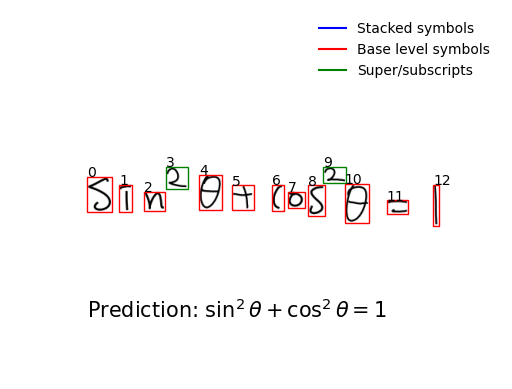

In [6]:
img_idx = 9
symbs, levels, stack, script_levels, extend_list, fig, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

ax.text(100, 400, r'Prediction: ' + eqstr, fontsize=15)
ax.set_frame_on(False)
ax.tick_params(axis='both',which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
fig.savefig('../figures/perfect_prediction.png')

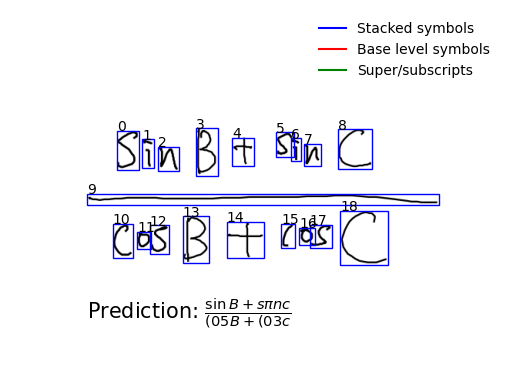

In [74]:
img_idx = 16
symbs, levels, stack, script_levels, extend_list, fig, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

ax.text(100, 400, r'Prediction: ' + eqstr, fontsize=15)
ax.set_frame_on(False)
ax.tick_params(axis='both',which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
fig.savefig('../figures/imperfect_prediction.png')

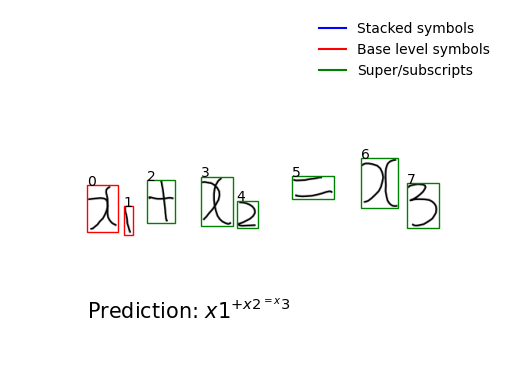

In [81]:
img_idx = 219
symbs, levels, stack, script_levels, extend_list, fig, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

ax.text(100, 400, r'Prediction: ' + eqstr, fontsize=15)
ax.set_frame_on(False)
ax.tick_params(axis='both',which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
fig.savefig('../figures/imperfect_prediction2.png')

### Evaluating the performance of the full pipeline

Now that the full pipeline is working, we want to know how well it does at actually predicting the equation label.
In order to gauge this, we will use the 'damerau-levenshtein distance', which measures how many symbols in two strings are different or need to be transposed

First let's retrieve the images we want to predict on

And load in the corresponding equation labels

In [11]:
#equation labels
with open(eq_dir + 'eq_labels.txt') as f:
    full_labels = f.readlines()
full_labels = [label[:-2].split(':: ')[1] for label in full_labels if 'eq' in label]

In [12]:
print(len(full_labels), len(full_eq_imgs))

1129 1129


In [13]:
comp_l = ['\\sum', '\\lim']
lim_labels = [label for label in full_labels if comp_l[0] in label or comp_l[1] in label]
trig_l = ['\\cos', '\\tan', '\\sin']
trig_labels = [label for label in full_labels if (trig_l[0] in label or trig_l[1] in label or trig_l[2] in label) and label not in lim_labels]


In order to make sure my equation strings and the labels look as similar as possible, I 'reprocess' the equation labels. One example of why this is necessary is that in the equation labels, if a single symbol is in a super or subscript ('^' or '_'), the symbol will somtimes not have curly brackets around them. 

Additionally, when calculating the damerau-levenshtein distance, I really want to equate symbols with symbols - not pure string characters. For example, if my model predicts a 6, but the actual label is \\theta, the penalty would be that we got 6 characters wrong, while it should really just be one. That's why when comparing the actual distance, I use 'relabeled' equations, where each symbol, or curly bracket is relabeled with a single ascii character.

In [14]:
def reprocess_eq(input_eq):
    """
    Reprocess the equation label, so that the comparison with the predicted equation label can be made
    Because I'm using the demerau-levenshtein distance to compare the predicted and actual equation strings
    it's important that the two are formatted as similarly as possible
    Input:
        equation string, read in from eq_labels.txct
    Returns:
        reprocessed equation string
    """
    
    #remove all whitespace and math mode markings ($), and make sure brackets are always labeled the same way
    input_eq = input_eq.replace('$', '').replace('\\left(','(').replace('\\right)',')').replace('\\)',')').replace('\\(','(').replace('\\lt','<').replace('\\gt','>')
                                                                                                                            
    #add curly brackets around superscripts and subscriptt
    br_ct = 0
    idx_l = []
    
    #first count how many instances of ^ and _ NOT followed by a curly bracket there are
    ss_list = ['^', '_']
    for i,s in enumerate(input_eq[:-1]):
        if s in ss_list and input_eq[i+1] != '{':
            idx_l.append(i+1)
            br_ct += 1
        
    #then rewrite the string piece by piece, adding curly opening and closing brackets where necessary
    input_eq_n = ''
    p = 0
    at_end = False
    for i in range(br_ct):

        input_eq_n += input_eq[p:idx_l[i]] + '{' + input_eq[idx_l[i]] + '}'
        if idx_l[i] == len(input_eq) - 1:
            at_end = True
        if at_end == False:
            p = idx_l[i]+1
            
    if at_end == False:
        input_eq_n += input_eq[p:]
    return input_eq_n

In [15]:
def relabel_equations(input_eq1, input_eq2):
    """
    Given two equation strings, split them by several types of delimiters at the same time,
    then find the number of unique entries in the total of two lists, and then relabel each unique entry and put it back into string type
    This so I can calculate the demerau-levenshtein distance without eg \\theta counting for more than b or a 
    Returns:
        two new equation strings, where each single character is replaced by an ASCII character
    """
    #ascii symbols
    charlist = string.printable

    #split both equations according to a bunch of delimiters
    delimiters = ['{','}','^','_','-','\+','\(','\)','=','1','2','3','4','5','6','7','8','9','0',' ']
    del_str = '|'.join(delimiters)
    #wrapping the delimiter string in parenthesis to make sure the delimiters are kept in as well
    input_eq1_l = re.split('(' + del_str + ')', input_eq1.lower())
    input_eq2_l = re.split('(' + del_str + ')', input_eq2.lower())
    
    #remove whitespace entries 
    input_eq1_l = [i for i in input_eq1_l if i != '' and i!= ' ']
    input_eq2_l = [i for i in input_eq2_l if i != '' and i!= ' ']

    #find the set of unique symbols of the combined lists
    n_unique  = list(set(input_eq1_l + input_eq2_l))
    
    #turn into arrays for easier indexing
    input_eq1_l, input_eq2_l = np.array(input_eq1_l), np.array(input_eq2_l)
    
    for i,val in enumerate(list(n_unique)):
        if val in input_eq1_l:
            input_eq1_l[input_eq1_l == val] = charlist[i]
        if val in input_eq2_l:
            input_eq2_l[input_eq2_l == val] = charlist[i]
            
    relabeled_eq1 = ''.join(list(input_eq1_l))
    relabeled_eq2 = ''.join(list(input_eq2_l))

    return relabeled_eq1, relabeled_eq2

Now let's go through the full pipeline, and calculate the levenshtein-damerau distance between the predicted and actual equation strings

In [16]:
lvs_n, lvs_c, lvs_t = [],[],[] #simple equations, 'complex' equations (lim or sum sign) and 'trig equations'
lvs_a = [] #all equations
for a in range(len(full_labels)):
    if a%100==0:print(a)
    
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    if full_labels[a] in lim_labels:
        lvs_c.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t.append(dl_dist)
    else:
        lvs_n.append(dl_dist)
    lvs_a.append(dl_dist)
lvs_a = np.array(lvs_a)

0
100
200
300
400
500
600
700
800
900
1000
1100


Let's see the distribution of edit distances, for the 3 types of equations, as well as the combined set:

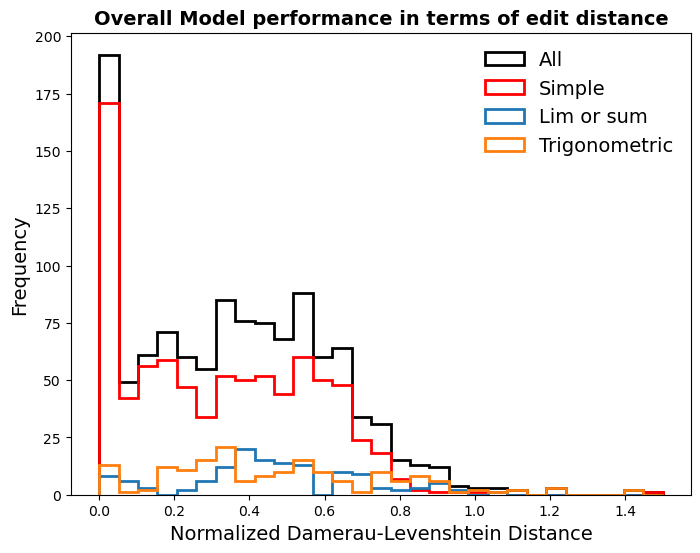

In [63]:
lbins = np.linspace(0, 1.5, 30)
plt.figure(figsize=(8, 6))
plt.hist(lvs_a, bins=lbins, histtype='step', label='All', color='black', linewidth=2)
plt.hist(lvs_n, bins=lbins, histtype='step', label='Simple',  color='red', linewidth=2)
plt.hist(lvs_c, bins=lbins, histtype='step', label='Lim or sum', linewidth=2)
plt.hist(lvs_t, bins=lbins, histtype='step', label='Trigonometric', linewidth=2)

plt.xlabel('Normalized Damerau-Levenshtein Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(frameon=False, fontsize=14)
plt.title('Overall Model performance in terms of edit distance', fontweight='bold', fontsize=14)
plt.savefig('../figures/model_performance.png')
plt.show()

In [64]:
def print_dist_info(input_dists, label):
    print('-' * 30)
    print('Predictions for: ' +  label +' \n') 
    i_a = np.array(input_dists)
    p_0 = len(i_a[i_a == 0])/len(i_a)
    p_10 = len(i_a[i_a < 0.1])/len(i_a)
    p_25 = len(i_a[i_a < 0.25])/len(i_a)
    p_50 = len(i_a[i_a < 0.5])/len(i_a)

    print('perfect predictions:', round(p_0, 4))
    print('normalized dist <0.1', round(p_10,4))   
    print('normalized dist <0.25', round(p_25,4))
    print('normalized dist <0.5', round(p_50,4))
    return

In [ ]:
dists_l = [lvs_a, lvs_n, lvs_t, lvs_c]
label_l = ['All eqs', 'Simple eqs', 'Trigonometric eqs', 'Complex eqs']
for i,d in enumerate(dists_l):
    print_dist_info(d, label_l[i])

------------------------------
Predictions for: All eqs 

perfect predictions: 0.1577
normalized dist <0.1 0.209
normalized dist <0.25 0.3667
normalized dist <0.5 0.659
------------------------------
Predictions for: Simple eqs 

perfect predictions: 0.1946
normalized dist <0.1 0.253
normalized dist <0.25 0.4404
normalized dist <0.5 0.7068
------------------------------
Predictions for: Trigonometric eqs 

perfect predictions: 0.0751
normalized dist <0.1 0.0809
normalized dist <0.25 0.1965
normalized dist <0.5 0.526
------------------------------
Predictions for: Complex eqs 

perfect predictions: 0.0373
normalized dist <0.1 0.1045
normalized dist <0.25 0.1343
normalized dist <0.5 0.5373


In what sort of equations did the model do particularly badly ?

In [66]:
idxs = np.where(lvs_a > 0.5)[0]

------------------------------
IDX: 206
ACTUAL EQ:  \log_{2} 8 + \log_{3} 9 + \log_{4} 1 6
PREDICTED EQ:  1 \theta g 2^{ 8  +  1  \theta  y  3^{ 9  +  \log } 4^{ 1  6}}
DISTANCE: 0.7619047619047619


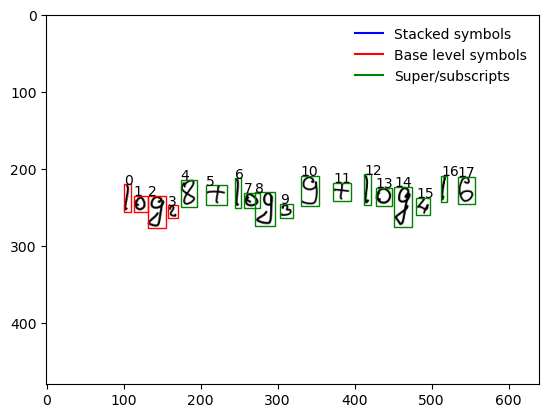

------------------------------
IDX: 208
ACTUAL EQ:  x_{4} = -\sqrt{2}
PREDICTED EQ:  x = - \cos 2
DISTANCE: 0.6363636363636364


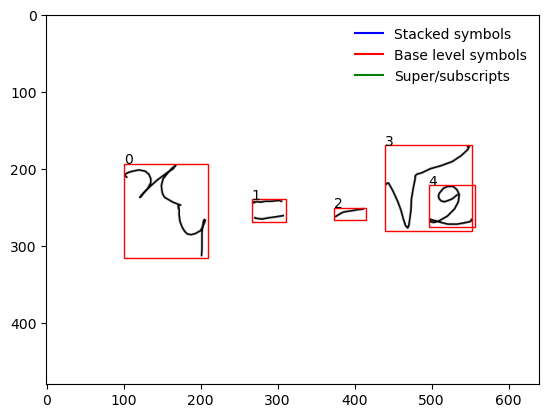

------------------------------
IDX: 209
ACTUAL EQ:  x=\alpha_{1} y_{1}+\ldots+\alpha_{n+1}y_{n+1}
PREDICTED EQ:  2 = \alpha 1 y + - - + a \lim y H
DISTANCE: 0.7586206896551724


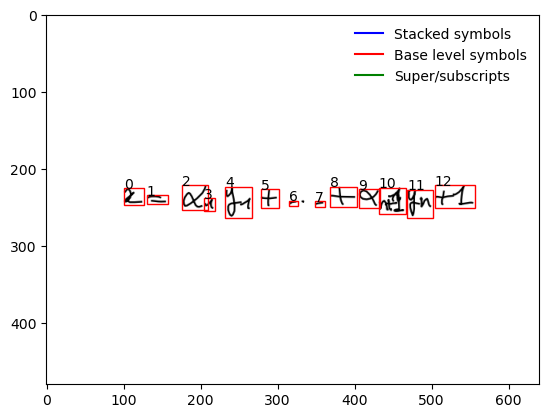

------------------------------
IDX: 218
ACTUAL EQ:  \sqrt{1 + \sqrt{2 + \sqrt{3 + \sqrt{4}}}}
PREDICTED EQ:  - 1 + - 2 + 3 + \pi 4}
DISTANCE: 0.5789473684210527


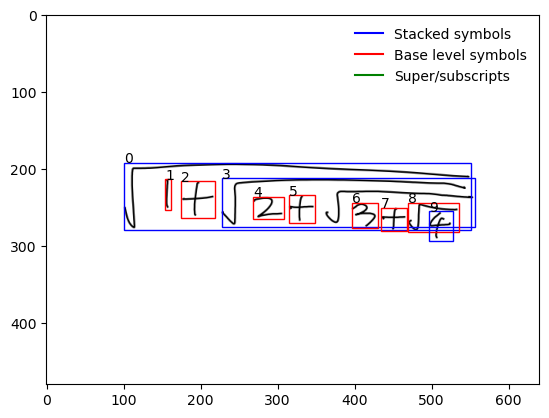

------------------------------
IDX: 219
ACTUAL EQ:  x_{1} + x_{2} = x_{3}
PREDICTED EQ:  x 1^{ +  x  2^{ =  x} 3}
DISTANCE: 0.5294117647058824


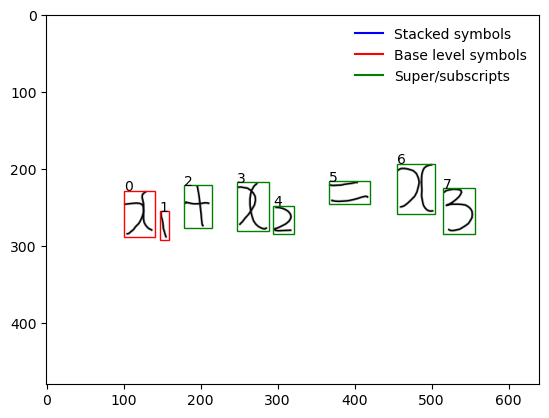

In [35]:
for a in idxs[45:50]:
    symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img(full_eq_imgs[a], plot=True)
    pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    actual_eq = reprocess_eq(full_labels[a])

    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    print('-' *30)
    print('IDX:', a)
    print('ACTUAL EQ:', actual_eq)
    print('PREDICTED EQ:', predicted_eq)
    print('DISTANCE:', dl_dist)
    
    plt.show()

Where did the model do particularly well?

In [36]:
idxs = np.where(lvs_a == 0)[0]

------------------------------
IDX: 225
ACTUAL EQ:  x_{i} - x_{i + 1} + x_{i + 2}
PREDICTED EQ:  x_{ 1} - x_{ i  +  1} + x_{ i  +  2}
DISTANCE: 0.0


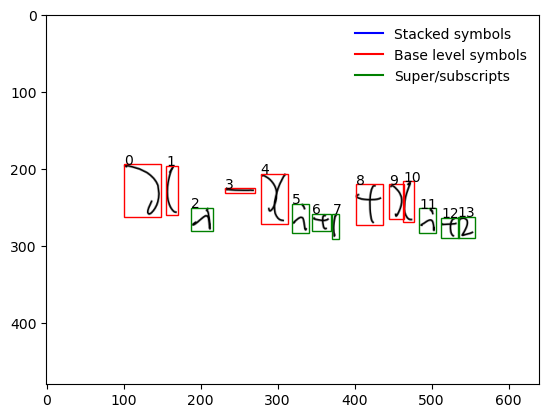

------------------------------
IDX: 226
ACTUAL EQ:  3 0 \times 2 9 x^{2 8}
PREDICTED EQ:  3 0 \times 2 9 x^{ 2  8}
DISTANCE: 0.0


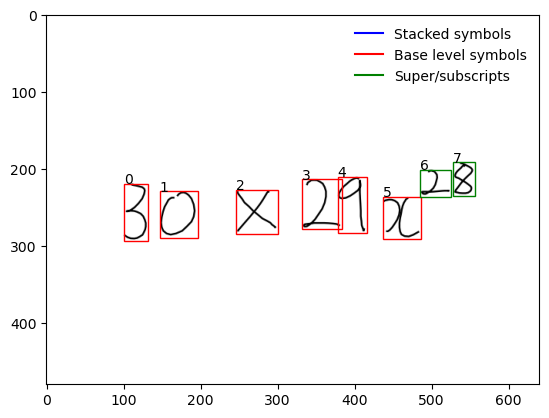

------------------------------
IDX: 232
ACTUAL EQ:  \int ( 2^{x} - 3 e^{x} ) d x
PREDICTED EQ:  \int ( 2^{ x} - 3 e^{ x} ) d x
DISTANCE: 0.0


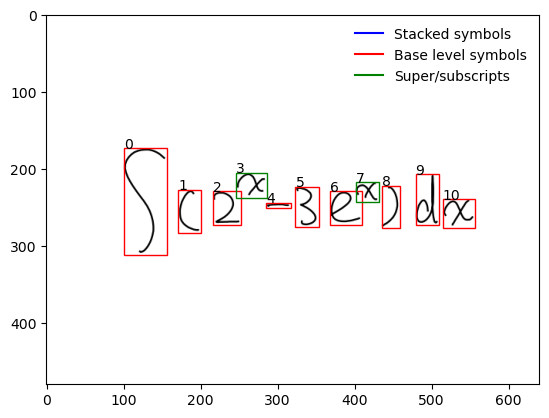

------------------------------
IDX: 238
ACTUAL EQ:  a + b + c + d + e
PREDICTED EQ:  a + b + C + d + e
DISTANCE: 0.0


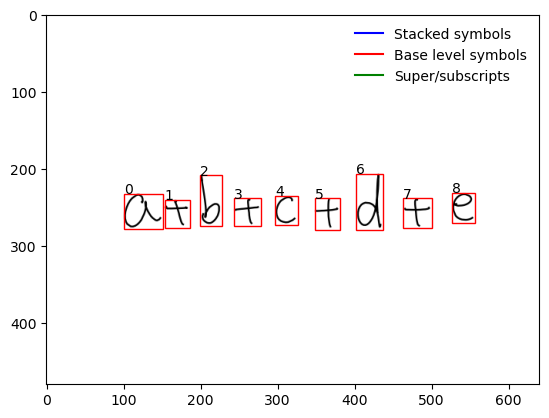

------------------------------
IDX: 252
ACTUAL EQ:  e = 2
PREDICTED EQ:  e = 2
DISTANCE: 0.0


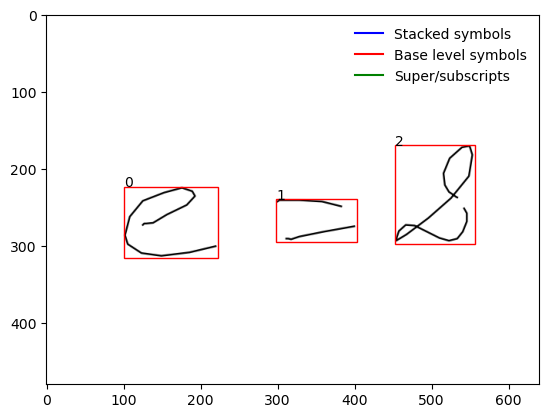

In [37]:
for a in idxs[45:50]:
    symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img(full_eq_imgs[a], plot=True)
    pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    actual_eq = reprocess_eq(full_labels[a])

    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    print('-' *30)
    print('IDX:', a)
    print('ACTUAL EQ:', actual_eq)
    print('PREDICTED EQ:', predicted_eq)
    print('DISTANCE:', dl_dist)
    
    plt.show()

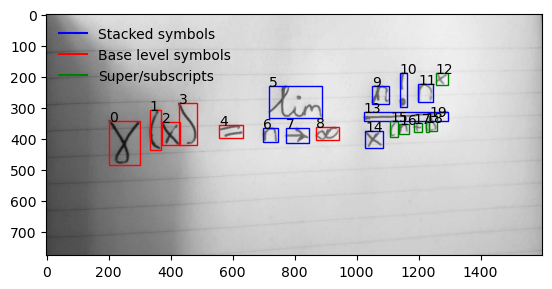

In [7]:
symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img('../img_data/handwritten/math_martijn.jpeg', plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)


In [8]:
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
display(Latex(eqstr))


<IPython.core.display.Latex object>

In [9]:
eqstr.replace(' ','')

'$8(X)=\\lim_{n\\rightarrow}\\infty\\frac{n!n^{k}}{\\times^{(n+1\\prime}}$'

That's almost correct! with the exception of the infinity symbol not being part of the lim, and the closing bracket in the divisor

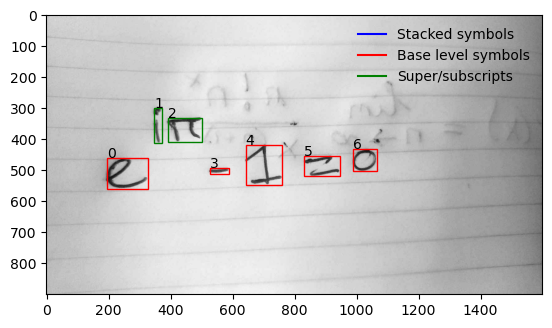

In [10]:
symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img('../img_data/handwritten/math_martijn3.jpeg', plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)


In [11]:
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
display(Latex(eqstr))

<IPython.core.display.Latex object>